# Used car price prediction with ML algorithms

The following project aims to analyze a dataset containing data about audi cars to extract useful insights and to eventually develop a ML algorithm to predict the price of a used audi car given some fesatures.<br>
The Project is strucured as follows:<br>

-Data Cleaning<br>
-Exploratory Data Analysis<br>
-Data Preparation for ML modeling<br>
-ML modeling<br>
-Results Summary<br>


The best ML algorithm for regression was XGBoost with RMSE=2264 and R2=0.951


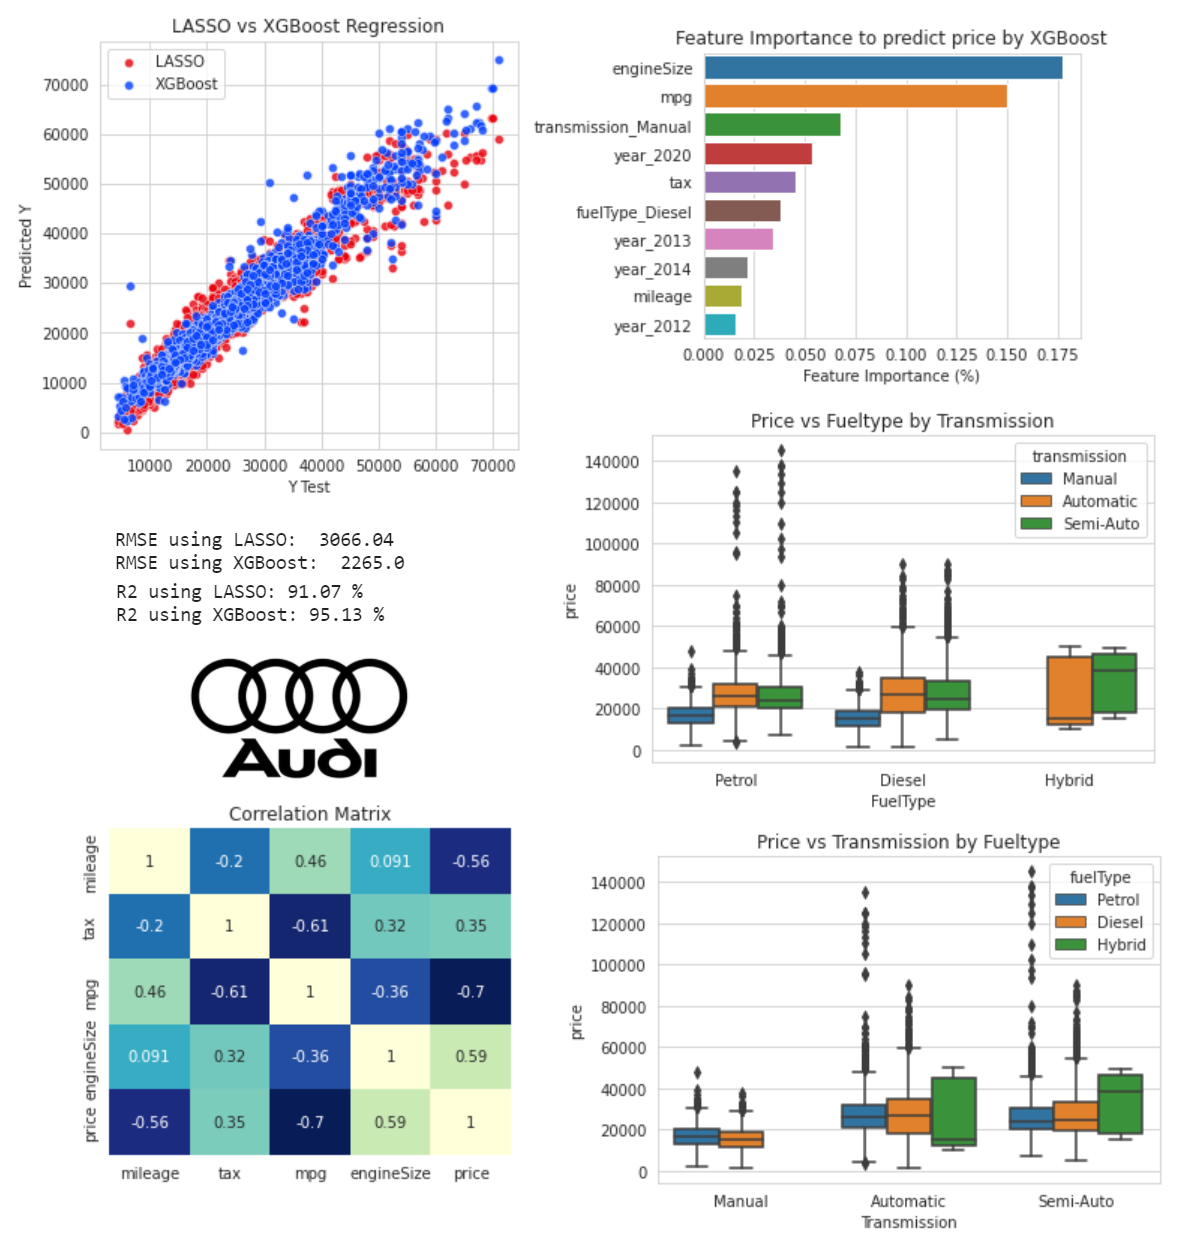

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.linear_model import Lasso
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import r2_score

sns.set_style("whitegrid")
sns.despine()
sns.set_color_codes('bright')

In [ ]:
df=pd.read_csv('/kaggle/input/used-car-dataset-ford-and-mercedes/audi.csv',skipinitialspace=True)

During the model deployment, I noticed that the values in the model columns had a blank space in front. For this reason, I decided to add "skipinitialspace=True" during the creation of the dataframe.

In [ ]:
df.head()

I will reorder the columns to group the categorical variables first and then the numerical ones

In [ ]:
df=df[['model','year','transmission','fuelType','mileage','tax','mpg','engineSize','price']]

In [ ]:
df.head(10)

In [ ]:
df.info()

In [ ]:
df['year'] = df['year'].astype(object)

It looks like there are no missing values.

# Exploratory Data Analysis

In [ ]:
df_clean = df.copy()

First, we need to understand if excluding the mileage, which heavily depends on the owner of the car, the other features uniquely identify a car or not.

In [ ]:
df_models=df.drop(['price','mileage','tax'], axis=1).drop_duplicates().sort_values(by=['model','year','fuelType'])
df_models.head()

Apparently the mpg and engineSize are not uniquely identified by the car model, year, transmission and fuelType.

## Categorical features Analysis

In the following, categorical features will be analyzed

In [ ]:
#Convert year column to object so we can include it in the categorical mask
df['year']=df['year'].astype(object)

In [ ]:
# Create a boolean mask for categorical columns
categorical_mask = (df.dtypes == object)

In [ ]:
categorical_columns = df.columns[categorical_mask].tolist()

In [ ]:
print(df[categorical_columns].head())

In [ ]:
df_cat=df[categorical_columns]

In [ ]:
df_cat['price']=df['price']

In [ ]:
df_cat.head()

### How is the fueltype related to the price?

In [ ]:
sns.boxplot(x='fuelType', y='price', data=df_cat, hue='transmission');
plt.xlabel('FuelType');
plt.title('Price vs Fueltype by Transmission');

We can see that Petrol cars are more expensive and present lots of outliers values. In particular, among the Petrol cars, those with Automatic and Semi-Auto transmission appears to be the most expensive, while the cars with a manual transimission are cheaper.<br>
Hybrid cars looks like to have no outliers.

### How is the Transmission related to the price?

In [ ]:
sns.boxplot(x='transmission', y='price', data=df_cat, hue='fuelType');
plt.xlabel('Transmission');
plt.title('Price vs Transmission by Fueltype');

From this plot it is possible to assert that cars with an Automatic or Semi-Automatic transmission are on average more expensive than cars with manual transmission. In particular, it is possible to say that while cars with manual transmission have a more similar price, cars with automatic or semi-auto transmission have a wider range of prices. Finally, Hybrid cars looks to have a more similar price with no outliers.

## Numerical featurs analysis

In [ ]:
df.describe()

# Outlier Detection

We will start investigating multivariate outliers by analyzing the correlation matrix between the numerical features

In [ ]:
sns.heatmap(df.corr(), cmap='Blues_r', annot=True)
plt.title('Correlation Matrix')

We should investigate Multivariate outliers for the features with high correlations:<br>
price-mpg<br>
price-enginesize<br>
price-mileage<br>
tax-mpg<br>

In [ ]:
max_threshold = df['price'].quantile(0.996)
min_threshold = df['price'].quantile(0.004)
max_threshold2 = df['mpg'].quantile(0.996)
min_threshold2 = df['mpg'].quantile(0.004)
max_threshold3 = df['mileage'].quantile(0.996)
min_threshold3 = df['mileage'].quantile(0.004)
max_threshold4 = df['engineSize'].quantile(0.996)
min_threshold4 = df['engineSize'].quantile(0.004)
max_threshold5 = df['tax'].quantile(0.996)
min_threshold5 = df['tax'].quantile(0.004)

In [ ]:
sns.scatterplot(y='price', x='mpg', data=df)
plt.axhline(y=max_threshold, color='r')
plt.axhline(y=min_threshold, color='r')
plt.show()

In [ ]:
sns.scatterplot(x='price', y='mpg', data=df)
plt.axhline(y=max_threshold2, color='r')
plt.axhline(y=min_threshold2, color='r')
plt.show()

In [ ]:
df_clean = df_clean[((df_clean['price']>min_threshold) & (df_clean['mpg']>min_threshold2)) &
        ((df_clean['price']<max_threshold) & (df_clean['mpg']<max_threshold2))]

In [ ]:
print('We removed {} outliers!'.format(len(df)-len(df_clean)))

In [ ]:
sns.scatterplot(y='price', x='engineSize', data=df)
plt.axhline(y=max_threshold, color='r')
plt.axhline(y=min_threshold, color='r')
plt.show()

In [ ]:
sns.scatterplot(x='price', y='engineSize', data=df_clean)
plt.axhline(y=max_threshold4, color='r')
plt.axhline(y=min_threshold4, color='r')
plt.show()

In [ ]:
df_clean = df_clean[((df_clean['price']>min_threshold) & (df_clean['engineSize']>min_threshold4)) &
        ((df_clean['price']<max_threshold) & (df_clean['engineSize']<max_threshold4))]

In [ ]:
print('We removed {} outliers!'.format(len(df)-len(df_clean)))

In [ ]:
sns.scatterplot(y='price', x='mileage', data=df)
plt.axhline(y=max_threshold, color='r')
plt.axhline(y=min_threshold, color='r')
plt.show()

In [ ]:
sns.scatterplot(x='price', y='mileage', data=df)
plt.axhline(y=max_threshold3, color='r')
plt.axhline(y=min_threshold3, color='r')
plt.show()

In [ ]:
df_clean = df_clean[((df_clean['price']>min_threshold) & (df_clean['mileage']>min_threshold3)) &
        ((df_clean['price']<max_threshold) & (df_clean['mileage']<max_threshold3))]

In [ ]:
print('We removed {} outliers!'.format(len(df)-len(df_clean)))

In [ ]:
sns.scatterplot(y='mpg', x='tax', data=df)
plt.axhline(y=max_threshold2, color='r')
plt.axhline(y=min_threshold2, color='r')
plt.show()

In [ ]:
sns.scatterplot(x='mpg', y='tax', data=df)
plt.axhline(y=max_threshold5, color='r')
plt.axhline(y=min_threshold5, color='r')
plt.show()

In [ ]:
df_clean = df_clean[((df_clean['mpg']>min_threshold2) & (df_clean['tax']>min_threshold5)) &
        ((df_clean['mpg']<max_threshold2) & (df_clean['tax']<max_threshold5))]

In [ ]:
print('We removed {} outliers!'.format(len(df)-len(df_clean)))

In the following, we will analyze each numerical feature

## mpg analysis 

In [ ]:
sns.displot(x='mpg', data=df_clean)

The data looks normal, thanks to the previous outlier removal

In [ ]:
sns.boxplot(x='mpg', data=df_clean)

It looks like there is still an outlier!

In [ ]:
df_clean.loc[df_clean['mpg']>80]

It will be removed now !

In [ ]:
df_clean = df_clean.loc[df_clean['mpg']<80]

## mileage analysis

In [ ]:
sns.displot(x='mileage', data=df_clean)

mileage has a right skewed distribution. 

In [ ]:
sns.boxplot(x='mileage', data=df_clean)

From the boxplot we can see a lot of outlier values. They are due to the right skewed nature of the distribution.

## tax analysis

In [ ]:
sns.displot(x='tax', data=df_clean)

In [ ]:
sns.boxplot(x='tax', data=df_clean)

The distribution looks right skewed with outliers on both the left and right of the distribution.

## Engine size analysis

In [ ]:
sns.displot(x='engineSize', data=df_clean)

In [ ]:
sns.boxplot(x='engineSize', data=df_clean)

From these plots it looks like there are few outliers !

In [ ]:
print('There are {} cars with an engine size over 3'.format(len(df_clean.loc[df_clean['engineSize']>=2.8])))
print('There are {} cars with an engine size over 3.4'.format(len(df_clean.loc[df_clean['engineSize']>=3.2])))
print('There are {} cars with an engine size over 3.8'.format(len(df_clean.loc[df_clean['engineSize']>3.8])))

Which are the cars with an engine size over 3.8?

In [ ]:
df_clean.loc[df_clean['engineSize']>3.8]['model'].value_counts()

Most of them are Audi Q7 and RS6.

## price analysis

In [ ]:
sns.displot(x='price', data=df_clean)

The distribution of 'price' looks almost like a gaussian distribution, but a bit right skewed.

In [ ]:
sns.boxplot(x='price', data=df_clean)

## Correlation Matrix

In [ ]:
sns.heatmap(df_clean.corr(),annot=True, cmap='YlGnBu_r')
plt.title('Correlation Matrix');

From the heatmap, we can say the following about the price:<br>
There is a quite moderate negative correlation (-0.7) between the mpg and the price. This means that cars with high mpg tends to be cheaper.<br>
There is a quite moderate negative correlation (-0.56) between the mileage and the price. This means that cars with a higher mileage tend to be cheaper.<br>
There is a small positive correlation also between the tax and the price. Cars with higher tax tends to cost more.
Finally, there is a moderate positive correlation also between the enginesize and the price. Cars with higher enginesize tends to cost more.

Other interesting information not related to the price are:<br>
There is a moderate positive correlation (0.46) between the mpg and mileage: cars with high mpg tends to have a higher mileage<br>
There is a quite moderate negative correaltion (-0.61) between tax and mpg. Cars with high mpg tends to have lower tax.





# Data Preparation for modeling

In [ ]:
df_clean.head()

In [ ]:
df_clean.describe()

## One Hot encoding

In [ ]:
df_clean[categorical_columns].info()

One Hot Encoding will be performed by the convenient function get dummies from pandas.

In [ ]:
encoded_df=pd.get_dummies(df_clean)
encoded_df.head()

## Prepare the data for learning

In [ ]:
X=encoded_df.drop('price', axis = 1).values

In [ ]:
y=encoded_df['price'].values

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [ ]:
scaler = StandardScaler()

In [ ]:
scaler.fit(X_train)

In [ ]:
X_train = scaler.transform(X_train)          # Apply Standardization on X_train
X_test = scaler.transform(X_test)            # Apply Standardization on X_test

## LASSO

In [ ]:
lm_lasso=Lasso(alpha = 2, max_iter = 10000, tol = 1e-5)
lm_lasso.fit(X_train,y_train)
y_pred_lm_lasso = lm_lasso.predict(X_test)
mse_lm_lasso = MSE(y_test, y_pred_lm_lasso)
print("RMSE using LASSO: ", np.sqrt(mse_lm_lasso))

## XGBoost

In [ ]:
xgb_model=xgb.XGBRegressor(n_estimators=1500, max_depth=4, learning_rate=0.1)

In [ ]:
xgb_model.fit(X_train, y_train)

In [ ]:
y_pred_xgb = xgb_model.predict(X_test)

In [ ]:
print("Best rmse:", np.sqrt(MSE(y_pred_xgb,y_test)))
print("R2 using XGBoost: ", r2_score(y_test, y_pred_xgb))

# Results Summary

In [ ]:
plt.figure(figsize = (5,5))
sns.scatterplot(x=y_test, y=y_pred_lm_lasso, label='LASSO', alpha=0.8, color='r')
sns.scatterplot(x=y_test, y=y_pred_xgb, label='XGBoost',alpha=0.8, color='b')
plt.xlabel('Y Test')
plt.ylabel('Predicted Y')
plt.legend(loc='upper left')
plt.title('LASSO vs XGBoost Regression')

In [ ]:
print("RMSE using LASSO: ", np.round(np.sqrt(mse_lm_lasso),2))
print("RMSE using XGBoost: ", np.round(np.sqrt(MSE(y_pred_xgb,y_test))))

In [ ]:
print("R2 using LASSO: {} % ".format(np.round(r2_score(y_test, y_pred_lm_lasso)*100,2)))
print("R2 using XGBoost: {} % ".format(np.round(r2_score(y_test, y_pred_xgb)*100,2)))

By looking at the RMSE and R2 scores, we can conclude that the best performing algorithm is Xgboost.

# Feature Importance

I will create dataframe to host the feature names and importance from XGBoost

In [ ]:
xgb_model.feature_names = encoded_df.drop('price', axis = 1).columns

In [ ]:
feat_df= pd.DataFrame({'feature': xgb_model.feature_names,'importance':xgb_model.feature_importances_})

Then, I will sort it by 'importance', creating a new sorted dataframe by importance

In [ ]:
sorted_df=feat_df.sort_values('importance', ascending=False)

Then I can get the top 10 most important features:

In [ ]:
sns.barplot(x='importance', y='feature', data=sorted_df.head(10))
plt.title('Feature Importance to predict price by XGBoost')
plt.xlabel('Feature Importance (%)')

It is interesting to notice that there are 3 vehicle names in the top features and other encoded features. This is due to the use of one hot encoding.

We could exclude car names and check which would be then the top 10 features. We will check the presence of 'model' in the feature column by using a regex

In [ ]:
feat_df2 = feat_df[~feat_df['feature'].astype(str).str.match("model")]

Then, as before, we create a new dataframe.

In [ ]:
sorted_df2=feat_df2.sort_values('importance', ascending=False)

In [ ]:
plt.figure(figsize=(4.5,3.5))
sns.barplot(x='importance', y='feature', data=sorted_df2.head(10))
plt.title('Feature Importance to predict price by XGBoost')
plt.xlabel('Feature Importance (%)')
plt.ylabel('')

It looks like enginesize and mpg are the most important factors to predict the price.